# Music Genre Classification

With the help of Neural Networks , this Notebook classifies music genres. The first and simpler approach is with a Feedforward Network and the second approach with Convolutional Networks.



In [27]:
import os
import time
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
from google.colab import drive
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Step1

Load data from Google Drive and transform labels from strings to integers from 0 to 3, keeping their mapping to class names. Then load the data into Dataloaders.

In [28]:
location = r'/content/drive/My Drive/data_music/'

train_path = location + 'train/mfccs/'
train_x = np.load(train_path + 'X.npy')
train_lbls = np.load(train_path + 'labels.npy')

test_path = location + 'test/mfccs/'
test_x = np.load(test_path + 'X.npy')
test_lbls = np.load(test_path + 'labels.npy')

val_path = location + 'val/mfccs/'
val_x = np.load(val_path + 'X.npy')
val_lbls = np.load(val_path + 'labels.npy')



*   Mel-frequency cepstrums(MFCC) are used for the FeedForward Model.



In [29]:
class mfccData(Dataset):
  def __init__(self, data, labels, labels_map , transform=None, target_transform=None) -> None:
    self.transform = transform
    self.target_transform = target_transform
    self.mfcclabels = []
    for l in labels:
      self.mfcclabels.append(labels_map[l])
    self.mfcclabels = np.array(self.mfcclabels)
    self.mfccdata = data

  def __len__(self):
    return len(self.mfcclabels)

  def __getitem__(self, index):
    sound = self.mfccdata[index]
    label = self.mfcclabels[index]
    if self.transform:
      sound = self.transform(sound)
    if self.target_transform:
      label = self.target_transform(label)

    return sound, label

inverse_labels_map = {
    'classical' : 0,
    'blues' : 1,
    'rock_metal_hardrock' : 2,
    'hiphop' : 3,
}


train_data = mfccData(train_x, train_lbls, inverse_labels_map, torch.tensor)
val_data = mfccData(val_x, val_lbls, inverse_labels_map, torch.tensor)
test_data = mfccData(test_x, test_lbls, inverse_labels_map, torch.tensor)

train_dataloader = DataLoader(train_data, batch_size=16,shuffle=True )
val_dataloader =  DataLoader(val_data, batch_size=16,shuffle=True )
test_dataloader =  DataLoader(test_data, batch_size=16,shuffle=True )

In [30]:
# Then the labels mapping
labelsMapping, indexed_labels_train = np.unique(train_lbls, return_inverse=True)
labelsMapping, indexed_labels_val = np.unique(val_lbls, return_inverse=True)
labelsMapping, indexed_labels_test = np.unique(test_lbls, return_inverse=True)

# Step 2
Fully Connected Neural Net. without activation functions and linear stacks.The data are in 1-D , so the flatten step is omitted.

In [31]:
class NeuralNetwork(nn.Module):
  def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
          nn.Linear(26, 128),
          nn.Linear(128, 32),
          nn.Linear(32,4),
      )

  def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

#Step 3

Define Training Function.


In [32]:
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)

# Calculation of losses
        pred = model(X.float())#forward()
        loss = loss_fn(pred, y)

        optimizer.zero_grad() #reset gradients
        loss.backward()       #calculation gradient of the loss
        optimizer.step()      #Update parameters based on the calculated derivatives of the previous step

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
  return model

In [33]:
# Confusion Matrix Plotting
def confusionMatrix(trues, preds):
    names =[labelsMapping[0], labelsMapping[1], labelsMapping[2],labelsMapping[3]]
    cfmatr = confusion_matrix(trues, preds)
    df_cm = pd.DataFrame(cfmatr/np.sum(cfmatr) * 4, index = [i for i in names],
                     columns = [i for i in names])
    plt.figure(figsize = (9,9))
    sns.heatmap(df_cm, cmap='viridis_r', annot=True)
    plt.show()

#Step 4

Define Evaluation Function.

In [34]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [35]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
#lists to use with metrics
    predictions = []
    labels = []
# the no_grad command tells PyTorch not to store the derivatives (as long as we check and don't train) We use it in the evaluation
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:

            X = X.to(device)
            y = y.to(device)

            pred = model(X.float()) # One step forwarard and calculation of pred outputs
#Appending lists for metrics
            predictions.append(pred.argmax(1).cpu().numpy())
            labels.append(y.cpu().numpy())

            test_loss += loss_fn(pred, y).item() #Calculation of  testlosss
#calculating whether the class with the highest probability is the correct one, and if so then adding it
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size

#np.array to use with  scikit
    predictions = np.array(predictions).flatten()
    labels = np.array(labels).flatten()
    accuracy = accuracy_score(labels, predictions)
    f1_macro = f1_score(labels, predictions, average='macro')
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} , Accuracy: {accuracy} , f1_macro: {f1_macro} \n")
    return test_loss , accuracy , f1_macro ,labels , predictions


# Step 5
Train and evaluate the neural network.




NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=26, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=4, bias=True)
  )
)
Epoch 1
-------------------------------
loss: 1.639816  [    0/ 3200]
loss: 1.378890  [ 1600/ 3200]
Epoch 2
-------------------------------
loss: 1.381306  [    0/ 3200]
loss: 1.390864  [ 1600/ 3200]
Epoch 3
-------------------------------
loss: 1.429140  [    0/ 3200]
loss: 1.215645  [ 1600/ 3200]
Epoch 4
-------------------------------
loss: 1.279674  [    0/ 3200]
loss: 1.313935  [ 1600/ 3200]
Epoch 5
-------------------------------
loss: 1.252643  [    0/ 3200]
loss: 1.352015  [ 1600/ 3200]
Epoch 6
-------------------------------
loss: 1.224906  [    0/ 3200]
loss: 1.332368  [ 1600/ 3200]
Epoch 7
-------------------------------
loss: 1.171867  [    0/ 3200]
loss: 1.182863  [ 1600/ 3200]
Epoch 8
-------------------------------
loss: 1.181051  [    0/

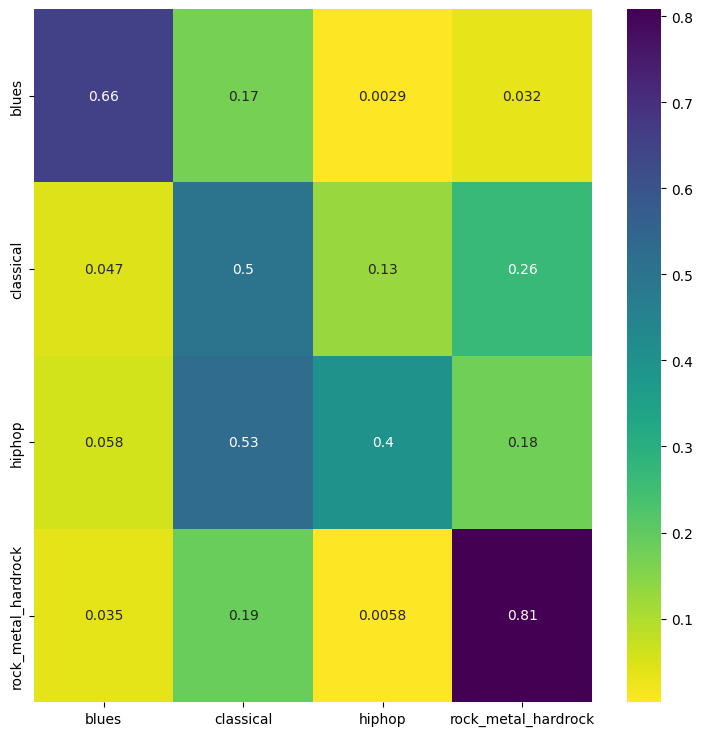

Done!

 Time needed: 8.00555419921875


In [36]:
learning_rate = 0.002
device = 'cpu'
simple_model = NeuralNetwork().to(device)
print(simple_model)
optimizer = torch.optim.SGD(simple_model.parameters(), lr = learning_rate)
loss_fn = nn.CrossEntropyLoss()

num_epochs = 30

start_time = time.time()
for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, simple_model, loss_fn, optimizer)
    if t == num_epochs - 1:
        test_loss, accuracy, f1_macro, labels , pred = test_loop(test_dataloader, simple_model, loss_fn)
        confusionMatrix(labels , pred)


print("Done!")
print(f'\n Time needed: {time.time() - start_time}')




Οι επιδόσεις δεν είναι τόσο καλές(60%) και από ένα σημείο και μετά το μοντέλο δεν "μαθαίνει" αφού οι αποδόσεις του περιστρέφονται γύρω από ένα μικρό εύρος τιμών.

# Step 6
Use GPU for training.



In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    print('GPU is available!')
else:
    print('GPU is not available, using CPU.')

#Repeat step 5
learning_rate = 0.002
simple_model = NeuralNetwork().to(device)
# print(simple_model)
optimizer = torch.optim.SGD(simple_model.parameters(), lr = learning_rate)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 30

start_time = time.time()
for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, simple_model, loss_fn, optimizer)
    test_loop(test_dataloader, simple_model, loss_fn)
print("Done!")
print(f'\n Time needed: {time.time() - start_time}')


# Step 7
Choose the best snapshot of the neural , comparing the f1 score each iteration

In [37]:
def train_with_validation(epochs, optimizer, tr_dataloader, val_dataloader, loss_fn , model):
  opt_model = None
  opt_f1 = 0
  opt_epoch = 0
  for e in range(epochs):
    print(f"Epoch {e+1}\n-------------------------------")
    train_loop(tr_dataloader, model, loss_fn, optimizer)
    loss , acc , f1 , true , pred = test_loop(val_dataloader ,model ,loss_fn)
    if f1 > opt_f1:
      opt_model = model
      opt_f1 = f1
      opt_epoch = e
  print(f'Best Epoch is : {opt_epoch} with {opt_f1} f1_score')
  return opt_model

Epoch 1
-------------------------------
loss: 0.755719  [    0/ 3200]
loss: 1.135663  [ 1600/ 3200]
Test Error: 
 Accuracy: 67.8%, Avg loss: 0.053079 , Accuracy: 0.6775 , f1_macro: 0.6768836875616537 

Epoch 2
-------------------------------
loss: 1.141454  [    0/ 3200]
loss: 1.563027  [ 1600/ 3200]
Test Error: 
 Accuracy: 64.6%, Avg loss: 0.055179 , Accuracy: 0.64625 , f1_macro: 0.6263436001591816 

Epoch 3
-------------------------------
loss: 0.477849  [    0/ 3200]
loss: 0.744055  [ 1600/ 3200]
Test Error: 
 Accuracy: 68.4%, Avg loss: 0.052056 , Accuracy: 0.68375 , f1_macro: 0.6703392136200969 

Epoch 4
-------------------------------
loss: 0.734441  [    0/ 3200]
loss: 1.194066  [ 1600/ 3200]
Test Error: 
 Accuracy: 65.8%, Avg loss: 0.054764 , Accuracy: 0.6575 , f1_macro: 0.649133179435957 

Epoch 5
-------------------------------
loss: 0.782641  [    0/ 3200]
loss: 1.052648  [ 1600/ 3200]
Test Error: 
 Accuracy: 63.1%, Avg loss: 0.054905 , Accuracy: 0.63125 , f1_macro: 0.6157020

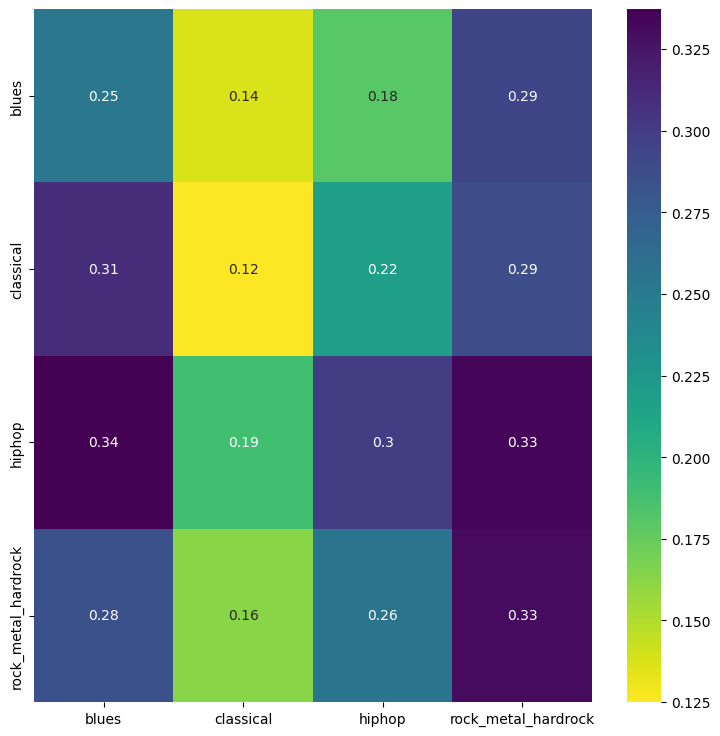

In [38]:
learning_rate = 0.002
optimizer = torch.optim.SGD(simple_model.parameters(), lr = learning_rate)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 30

start_time = time.time()
opt_model = train_with_validation(num_epochs, optimizer, train_dataloader, val_dataloader ,loss_fn, simple_model)
print(f'\n Time needed: {time.time() - start_time}')

loss , acc , f1 ,trues , pred = test_loop(test_dataloader ,opt_model ,loss_fn)
print(f'This is the Testing Metrics:\n')
print(f'loss:{loss} , accuracy:{acc} , f1:{f1}')
confusionMatrix(labels , pred)
# print(f'Best Model is : {opt_model}')